# Global Tunable Inexact Oracles :: 

**Version** : 1.0 ; pointwise tests in the meta-parameter space

`Performance analysis of deterministic gradient based methods using accuracy global tunable inexact oracles.`

**Author** : Ir. *Van Dessel*, Ph.D. candidate @EPL

**Comment** : For now on, let's stick to fully deterministic methods (however those might be inexact as well but there must be 
no source of randomness at each update step apart from oracle's content)

**What's next?** : General integer possibility for feasibility center and optimizer

In [1]:
## packages' import
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import wald,norm,f,expon,chi2,uniform
import scipy.linalg as la
from IPython.display import display,clear_output
from ipywidgets import *
import decimal

%matplotlib notebook

np.warnings.filterwarnings('ignore')

____________________________________________________________________________________

Creation of a problem
-------------------------------

In [2]:
# @instantiation of the possibility lists 

# objective function list
obj_list = ['generic','other'] # add practical things

# method list
met_list = ['gd']

# inaccuracy level distribution list
dst_list = ['uniform','exponential','F','chi2','wald']

# search space dimension 
d = 10

#####################################################################################################################################

# @creation of inherent widgets

widget_obj = widgets.Dropdown(
    options=obj_list,
    value=obj_list[0],
    description='obj. fun.: ',
)

widget_met = widgets.Dropdown(
    options=met_list,
    value=met_list[0],
    description='method: ',
)

widget_dst = widgets.Dropdown(
    options=dst_list,
    value=dst_list[0],
    description='distrib. level: ',
)

widget_d = widgets.IntSlider(
    value=d,
    min=1,
    max=100,
    step=1,
    description='dimension:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

widget_cons = widgets.Checkbox(
    value=False,
    description='constrained?',
    disabled=False
)

widget_distance = BoundedFloatText(
    value=1,
    min=0,
    max=1000.0,
    step=0.05,
    description='center norm:',
    disabled=False)

In [3]:
# @default Problem class
class Problem:
    
    f = lambda x: (1/2)*np.sum(x**2)
    dif_f = lambda x: x
    mu = 1
    L = 1
    d = 10
    m = 0
    constr = False
    x_star = np.zeros(d)
    scale = 5
    center = None
    type_dom = None
    update = lambda h,u: u
    
    # instance based content yet to come
    
def short_not(float_number):
    return '%.3e' % decimal.Decimal(str(float_number))
    
def present_Problem():
    
    print(' ')
    print('|| problem summary ||')
    print('---------------------')
    print(' ')
    if Problem.constr:
        if Problem.type_dom is 'box':
            print('=> constrained in a box defined by :')
            if Problem.d <= 5:
                buf='['+short_not(Problem.center[0]-Problem.scale)+' , '+short_not(Problem.center[0]+Problem.scale)+']'
                for elem in np.linspace(1,Problem.d-1,Problem.d-1):
                    buf+=' X ['+short_not(Problem.center[int(elem)]-Problem.scale)+' , '\
                    +short_not(Problem.center[int(elem)]+Problem.scale)+']'
            else:
                buf = 'U from i = 1 to '+str(Problem.d)+' [c_i - '+str(Problem.scale)+' , c_i + '+str(Problem.scale)+']'
            print(buf)
        else:
            print('=> constrainted in a ball defined by : ')
            print(' B := {x in R^'+str(int(Problem.d))+' | ||x-c|| <= '+str(Problem.scale)+'}')
    else: 
        print('=> unconstrained ')
    print(' ')
    print('dimension : '+str(int(Problem.d)))
    print('estimated strong convexity parameter : '+str(Problem.mu))
    print('estimated smoothness parameter : '+str(Problem.L))
    print('activated constraints at optimum : '+str(int(Problem.m)))
    if Problem.d <= 20:
        print('optimum : '+str(Problem.x_star))
    print(' ')
    
def reset_Problem():
    
    Problem.f = lambda x: (1/2)*np.sum((x-Problem.x_star)**2)
    Problem.f = lambda x: (x-Problem.x_star)
    Problem.mu = 1
    Problem.L = 1
    Problem.d = 10

In [4]:
### models x_*
def free(dist):
    
    direc = norm.rvs(loc=0, scale=1, size=Problem.d)
    Problem.x_star = dist*direc/la.norm(direc)
    
    Problem.center = Problem.x_star
    
    print(' ')
    print('=> a new optimizer has been chosen')
    if Problem.d <= 20:
        print(Problem.x_star)
    print(' ')
    
def ball_proj(u,center,scale):
    return center + (u-center)/np.max([scale,la.norm(u-center)])
    
def ball_constraint(center,m,scale):
    
    Problem.m = m
    Problem.scale = scale
    Problem.update = lambda h,u: ball_proj(u,Problem.center,Problem.scale)
    
    direc = norm.rvs(loc=0, scale=1, size=Problem.d)
    
    if m==1:
        Problem.x_star = center+scale*direc/la.norm(direc)
    else:
        Problem.x_star = center+(scale*np.random.uniform(0,1)**(1/Problem.d))*direc/la.norm(direc)
        
    print(' ')
    print('=> a new optimizer has been chosen')
    if Problem.d <= 20:
        print(Problem.x_star)
    print(' ')
    
def box_proj(u,center,scale):
    buf = []
    bounds = [center-scale,center+scale]
    for j in np.arange(len(u)):
        if u[j]<bounds[0][j]:
            buf.append(bounds[0][j])
        elif u[j]>bounds[1][j]:
            buf.append(bounds[1][j])
        else:
            buf.append(u[j])
    return np.array(buf)
        
def box_constraint(center,m,scale):
    
    Problem.m = m
    Problem.scale = scale
    Problem.update = lambda h,u: box_proj(u,Problem.center,Problem.scale)
    
    bounds = [center-Problem.scale,center+Problem.scale]
    
    if m>0:
        indices = np.random.choice(np.arange(Problem.d),m,False)
        buf = np.zeros(Problem.d)
        for elem in np.arange(Problem.d):
            if elem in indices:
                buf[elem] = np.random.choice([bounds[0][elem],bounds[1][elem]],1)[0]
            else:
                buf[elem] = np.random.uniform(bounds[0][elem],bounds[1][elem],1)
        Problem.x_star = buf
    else:
        Problem.x_star = np.random.uniform(bounds[0],bounds[1],Problem.d)
        
    print(' ')
    print('=> a new optimizer has been chosen')
    if Problem.d <= 20:
        print(Problem.x_star)
    print(' ')
    
def constraint(dist,cstr_type='box'):
    
    direc = norm.rvs(loc=0, scale=1, size=Problem.d)
    cent = dist*direc/la.norm(direc)
    
    Problem.center = cent
    
    widget_scale = BoundedFloatText(
    value=1,
    min=0,
    max=1000.0,
    step=0.05,
    description='scale:',
    disabled=False)
    
    if cstr_type is 'ball':
        
        Problem.type_dom = 'ball'
    
        widget_m = widgets.IntSlider(
        value=0,
        min=0,
        max=1,
        step=1,
        description='number of activated constraints at x_*:')
        
        interact(lambda m,scale: ball_constraint(cent,m,scale),m=widget_m,scale=widget_scale)
    
    else:
        
        Problem.type_dom = 'box'
        
        widget_m = widgets.IntSlider(
        value=0,
        min=0,
        max=Problem.d,
        step=1,
        description='number of activated constraints at x_*:')
        
        interact(lambda m,scale: box_constraint(cent,m,scale),m=widget_m,scale=widget_scale)

In [5]:
### models for f and del f

# generic
def generic(alpha=1,beta=1.3,gamma=4.5):
    
    # @priori s.c. and smoothness parameters
    Problem.mu = alpha
    Problem.L = alpha + 4*beta + gamma/2 
    
    yf = widgets.HTMLMath(value=r'$$f(x) = \frac{\alpha}{2}\,||x-x_*||^2 + \beta \, g(x-x_*) + \gamma \, [h(x) - h(x_*) \
    - \langle \nabla h(x_*) \, , \, x-x_* \rangle] $$')
    ye = widgets.Label(value='where')
    yg = widgets.HTMLMath(value=r'$$g(x) = \frac{1}{2}\,[x_{1}^2 + \sum_{i=1}^{d}\, (x_{i} - x_{i+1})^2 + x_{d}^2]$$')
    yh = widgets.HTMLMath(value=r'$$h(x) = \log(\sum_{i=1}^{d} \, e^{x_{i}})$$')
    display(yf,ye,yg,yh)
    
    def z(x):
        return (1/2)*np.sum(x**2)
    
    def grad_z(x):
        return x
    
    def g(x):
        return (1/2)*(x[0]**2 + x[-1]**2 + np.sum((x[:-1]-x[1:])**2))
    
    def grad_g(x):
        zer = np.zeros(1)
        _x = np.concatenate((zer,x[:-1]),axis=None)
        x_ = np.concatenate((x[1:],zer),axis=None)
        return 2*x - (_x + x_)
    
    def h(x):
        delta = np.max(x)
        return delta + np.log(np.sum(np.exp(x-delta)))
    
    def grad_h(x):
        delta = np.max(x)
        u = np.exp(x-delta)
        return u/np.sum(u)
    
    x_star = Problem.x_star
    h_star = h(x_star)
    grad_h_star = grad_h(x_star)
    
    # first order information
    
    Problem.f = lambda x: alpha*z(x-x_star) + beta*g(x-x_star) +\
            gamma*(h(x)-h_star-(grad_h_star@(x-x_star)))
    
    Problem.dif_f = lambda x: alpha*grad_z(x-x_star) + beta*grad_g(x-x_star)+\
            gamma*(grad_h(x)-grad_h_star)

In [6]:
def change_optimizer(dimension,boolean,distance=5):
    
    Problem.d = int(dimension)
    Problem.constr = boolean
    
    if boolean: # only box, ball
        
        widget_type = widgets.Dropdown(
        options=['box','ball'],
        value='box',
        description='constraint type: ')
        
        interact(lambda cstr_type: constraint(distance,cstr_type), cstr_type = widget_type)
        
    else:
        
        free(distance)
        

def change_obj(string):
    
    if string is 'generic':
        
        widget_alpha = BoundedFloatText(
            value=1.0,
            min=0,
            max=100.0,
            step=0.01,
            description='alpha:',
            disabled=False)
        
        widget_beta = BoundedFloatText(
            value=1.3,
            min=0,
            max=100000.0,
            step=0.05,
            description='beta:',
            disabled=False)
        
        widget_gamma = BoundedFloatText(
            value=4.5,
            min=0,
            max=500000.0,
            step=0.5,
            description='gamma:',
            disabled=False)
        
        # exact f,dif functions 
        interact(generic,alpha = widget_alpha,beta = widget_beta, gamma = widget_gamma);
        
    else:
        
        # default f,dif functions 
        reset_Problem()
        y = widgets.HTMLMath(value=r'$$f(x) = \frac{||x-x_*||^2}{2}$$')
        display(y)

In [7]:
# optimum 
interact(change_optimizer,dimension = widget_d,boolean = widget_cons, distance = widget_distance);

interactive(children=(IntSlider(value=10, continuous_update=False, description='dimension:', min=1), Checkbox(…

In [8]:
# objective function
interact(change_obj,string = widget_obj);

interactive(children=(Dropdown(description='obj. fun.: ', options=('generic', 'other'), value='generic'), Outp…

In [9]:
button = widgets.Button(description="Load Problem")
output = widgets.Output()

display(button, output)

def on_button_clicked(b):
    with output:
        clear_output()
        present_Problem()

button.on_click(on_button_clicked)

Button(description='Load Problem', style=ButtonStyle())

Output()

Non-dynamic oracle: base cost model
------------------------------------------------------

for all $k \in \{0,...,N-1\}$,

$$ \mathcal{M}_k(\delta_k) = \frac{c_1 \delta_k + c_2}{1+c_3 \delta_k}$$
(smooth convex)

lower bound for cost: 0.26666666666666666


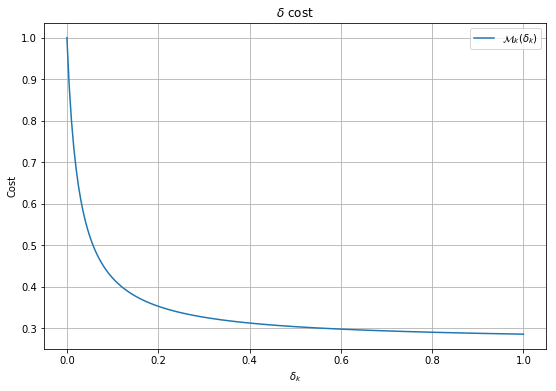

In [10]:
# c1 < c3*c2 to avoid convexity issues in (c1*delta + c2)/(1+c3*delta)
scaler = 50
c1 = 0.2*scaler
c2 = 1
c3 = 0.75*scaler
mix = c2*c3-c1
limit = c1/c3
L_cost = 2*c3*(c3*c2-c1) # see diff2_base_cost max ;)

def base_cost(delta):
    return np.sum((c1*delta+c2)/(1+c3*delta)) # indep. of iteration number !

def diff_base_cost(delta):
    return np.array([(c1-c3*c2)/(1+c3*(delta_j))**2 for delta_j in delta])

def diff2_base_cost(delta): # matrix stored in a vector
    return np.array([2*c3*(c3*c2 - c1)/(1+c3*(delta_j))**3 for delta_j in delta])

deltas = np.linspace(0,1,200)
plt.figure(figsize=(9,6))
plt.title('$\delta$ cost')
plt.xlabel('$\delta_k$')
plt.ylabel('Cost')
plt.grid()
plt.plot(deltas,(c1*(deltas)+c2)/(1+c3*(deltas)))
plt.legend(['$\mathcal{M}_k(\delta_k)$']);
print('lower bound for cost: '+str(limit))

Schedule optimization for exact, inexact tending to exact and inexact (KKT)
-------------------------------------------------------

cost of (kkt optimized) inexact : L and mu : 381.5915664443808
cost of exact : L_f and mu_f : 123.0
cost of exact : L and mu : 491.0


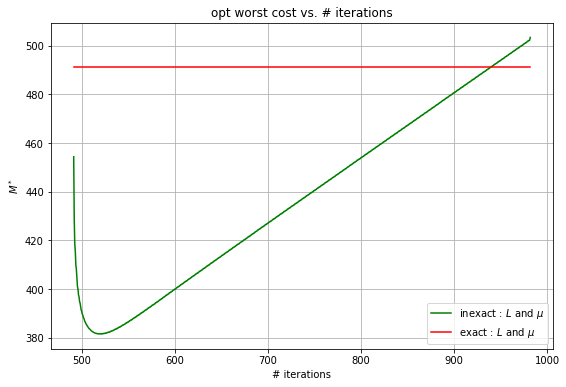

In [11]:
greedy = False

R = 10
epsilon = 1e-5

rho_exact = (1-(Problem.mu/Problem.L))
A_exact = lambda N: np.sum(rho_exact**(N-1-np.arange(N)))
lower,upper=0,1e5 # increase manually.. if no solution found
while upper-lower>1:
    N_test = np.ceil((lower+upper)/2)
    A_test = A_exact(N_test)
    if A_test*epsilon - ((Problem.L*R**2)/2)*rho_exact**N_test>0:
        upper = N_test
    else:
        lower = N_test
N_exact = upper

if greedy:
    L = Problem.L
    mu = Problem.mu
else:
    L = 2*Problem.L
    mu = Problem.mu/2

rho = (1-(mu/L))
A_inexact = lambda N: np.sum(rho**(N-1-np.arange(N)))
lower,upper=0,1e5 # increase manually.. if no solution found
while upper-lower>1:
    N_test = np.ceil((lower+upper)/2)
    A_test = A_inexact(N_test)
    if A_test*epsilon - ((L*R**2)/2)*rho**N_test>0:
        upper = N_test
    else:
        lower = N_test
N_inexact_min = upper

mix = c2*c3-c1
verbose_check = False


buf = np.max([2*N_inexact_min,np.floor(limit*N_exact)])
costs = np.linspace(np.max([N_inexact_min,2]),buf,np.min([1000,int(buf-N_exact)]))
list_costs = []
buf_cost = np.inf
base_sched = np.zeros(int(N_inexact_min))

for elem in costs:
    
    lower = 1
    upper = int(elem)
    
    a = rho**(N_inexact_min-1-np.arange(elem))
    A = np.sum(a)
    K = A*epsilon - ((L*R**2)/2)*rho**elem

    while upper-lower>1:
        mean = int(np.ceil([lower+(upper-lower)/2]))
        if verbose_check:
            print('test with : '+str(mean))
        feas = np.sqrt(np.max(a[:mean])/mix)
        attempt = (K*c3 + np.sum(a[:mean]))/(np.sum(np.sqrt(a[:mean]*mix)))
        if attempt>feas:
            lower = mean
            if verbose_check:
                print('ok with '+str(mean)+' non-zero deltas')
        else:
            upper = mean
            if verbose_check:
                print('not ok with '+str(mean)+' non-zero deltas')

    coeff_test = (K*c3 + np.sum(a[:lower+1]))/(np.sum(np.sqrt(a[:lower+1]*mix)))
    feas_test = np.sqrt(np.max(a[:lower+1])/mix)
    if coeff_test>feas_test:
        coeff = coeff_test
        new_base_sched = np.concatenate((np.ones(lower+1)*(coeff*np.sqrt(mix/a[:lower+1])-1)/c3,np.zeros(int(elem-lower-1))))
        ret = lower+1
    else:
        coeff = (K*c3 + np.sum(a[:lower]))/(np.sum(np.sqrt(a[:lower]*mix)))
        ret = lower
        new_base_sched = np.concatenate((np.ones(lower)*(coeff*np.sqrt(mix/a[:lower])-1)/c3,np.zeros(int(elem-lower))))
    new_cost = base_cost(new_base_sched)
    list_costs.append(new_cost)
    if new_cost<buf_cost:
        buf_cost = new_cost
        base_sched = new_base_sched
        a_sched = a
        A_sched = A
        K_sched = K
        ret_sched = ret

if len(costs)>1:
    plt.figure(figsize=(9,6))
    plt.title('opt worst cost vs. # iterations')
    plt.xlabel('# iterations')
    plt.ylabel('$M^*$')
    plt.grid()
    plt.plot(costs,np.array(list_costs),color='green')
    plt.plot(costs,np.ones(len(costs))*base_cost(np.zeros(int(N_inexact_min))),color='red')
    plt.legend(['inexact : $L$ and $\mu$','exact : $L$ and $\mu$']);
print('cost of '+'(kkt optimized) inexact : L and mu'+' : '+str(base_cost(base_sched)))
print('cost of '+'exact : L_f and mu_f'+' : '+str(base_cost(np.zeros(int(N_exact)))))
print('cost of '+'exact : L and mu'+' : '+str(base_cost(np.zeros(int(N_inexact_min)))))

The linear interpolation of the performance/overall cost under optimized $\{\delta_k\}_{k=0}^{N-1}$ schedule seems *quasi-convex*.

number of non lower-limit delta_k : 250


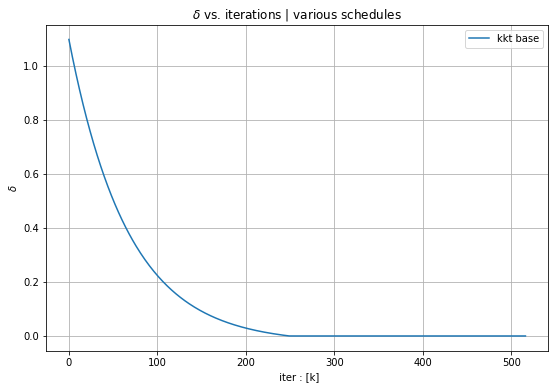

In [12]:
plt.figure(figsize=(9,6))
plt.title('$\delta$ vs. iterations | various schedules')
plt.xlabel(' iter : [k]')
plt.ylabel('$\delta$')
plt.grid()
plt.plot(np.arange(len(base_sched)),base_sched)
plt.legend(['kkt base']);
print('number of non lower-limit delta_k : '+str(ret_sched))

User's oracle strategy & method
----------------------------------------------

In [14]:
# test oracle

direc = np.random.normal(0,1,Problem.d)
x_start = Problem.x_star + R*direc/la.norm(direc) # for now on, not necessarily in Q for x_0

def delta_source_base(delta):
    return 0,np.sqrt(delta*(2*Problem.mu*Problem.L)/(2*Problem.L + Problem.mu))

def f_d_base(x,DELTA1=0):
    return Problem.f(x)

def g_d_base(x,DELTA2=0):
    direc = np.random.normal(0,1,Problem.d)
    return Problem.dif_f(x)+direc/la.norm(direc)*DELTA2

ValueError: operands could not be broadcast together with shapes (24,) (10,) 

In [42]:
# Proximal Gradient Descent with fixed step-size

# f_d => 0 th order oracle based on Problem.f 
# g_d => 1 th order oracle based on Problem.dif_f
# cost => cost funtion that can depend on both delta and k ; 
#  see models (version 1.0 => (same cost per iteration) cost(delta,k) = (c1*delta + c2)/(1+c3*delta)
# update => implements a proximal update (version 1.0 => (only projection))
# delta_schedule => oracle accuracy at step xxx

def inexact_cGD(f_d,g_d,update,delta_schedule,delta_source,x_0,x_star,h_sched,retrieve=True,verbose=False):
    r_list = []
    f_list = [f_d(x_0)]
    x_prev = x_0
    N = len(delta_schedule)
    if verbose:
        print(' => init. alg. iCGD <=')
        print(' ')
    for k in np.arange(len(delta_schedule)):
        delta_current = delta_schedule[k]
        DELTA1,DELTA2 = delta_source(delta_current)
        x_current = update(h_sched(delta_current),x_prev-h_sched(delta_current)*g_d(x_prev,DELTA2))
        if retrieve:
            r_val = la.norm(x_current-x_star)
            fg_val = f_d(x_current,DELTA1)
            if verbose:
                print('iteration '+ str(k) + ' || R value : '+str('{0:1.2e}'.format(r_val))+' , '+\
                      'f (tilde) value : '+str('{0:1.2e}'.format(fg_val)))
            r_list.append(r_val)
            f_list.append(fg_val)
        x_prev = x_current
    print(' ')
    if retrieve:
        return x_current,r_list,f_list
    else:
        return x_current

 
 
 
cost of (kkt optimized) inexact : L and mu : 245.9958238361096
cost of exact : L_f and mu_f : 77.0
cost of exact : L and mu : 317.0
gain using opt. procedure => 2.24e+01 %


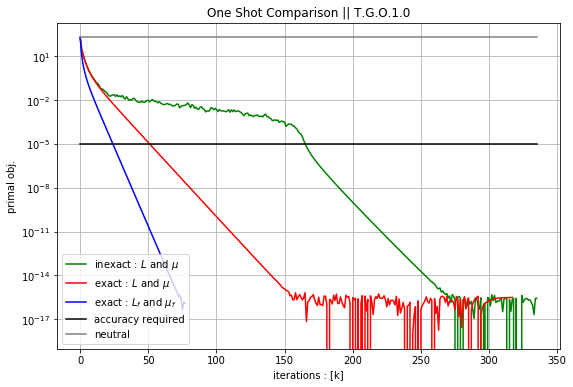

In [43]:
# testing time
    
x_inexact,r_list_inexact,f_list_inexact = inexact_cGD(f_d_base,g_d_base,Problem.update,\
                                                      base_sched,delta_source_base,x_start,Problem.x_star,lambda delta: 1/L)
x_exact,r_list_exact,f_list_exact = inexact_cGD(f_d_base,g_d_base,Problem.update,\
                                                np.zeros(int(N_exact)),delta_source_base,x_start,Problem.x_star,lambda delta: 1/Problem.L)

x_exact_bis,r_list_exact_bis,f_list_exact_bis = inexact_cGD(f_d_base,g_d_base,Problem.update,\
                                                np.zeros(int(N_inexact_min)),delta_source_base,x_start,Problem.x_star,lambda delta: 1/L)


# reminder
b1,b2 = base_cost(base_sched),base_cost(np.zeros(int(N_inexact_min)))
print('cost of '+'exact : L_f and mu_f'+' : '+str(base_cost(np.zeros(int(N_exact)))))
print('cost of '+'(kkt optimized) inexact : L and mu'+' : '+str(b1))
print('cost of '+'exact : L and mu'+' : '+str(b2))
print('gain using opt. procedure => '+str('{0:1.2e}'.format((b2-b1)*100/b2))+' %')
# plotting time
absx = np.arange(len(f_list_inexact))

plt.figure(figsize=(9,6))
plt.title('One Shot Comparison || G.T.O.1.0')
plt.grid()
plt.semilogy(absx,f_list_inexact-Problem.f(Problem.x_star),color='green')
plt.semilogy(np.arange(len(f_list_exact_bis)),f_list_exact_bis-Problem.f(Problem.x_star),color='red')
plt.semilogy(np.arange(len(f_list_exact)),f_list_exact-Problem.f(Problem.x_star),color='blue')
plt.semilogy(absx,np.ones(len(f_list_inexact))*epsilon-Problem.f(Problem.x_star),color='black')
plt.semilogy(absx,np.ones(len(f_list_inexact))*f_list_exact[0]-Problem.f(Problem.x_star),color='grey')
if len(f_list_inexact) < 1e2:
    plt.scatter(absx,f_list_inexact-Problem.f(Problem.x_star),color='green')
    plt.scatter(np.arange(len(f_list_exact_bis)),f_list_exact_bis-Problem.f(Problem.x_star),color='red')
    plt.scatter(np.arange(len(f_list_exact)),f_list_exact-Problem.f(Problem.x_star),color='blue')
plt.xlabel('iterations : [k]')
plt.ylabel('primal obj.')
plt.legend(['inexact : $L$ and $\mu$','exact : $L$ and $\mu$','exact : $L_f$ and $\mu_f$','accuracy required','neutral']);